### Visualizing TFIDF Models of the Arab Observer Pages that Mention Congo 1960-1961 and 1960-1966

This notebook contains the required code to make visualizations to analyze TFIDF models of the Arab Observer

In [3]:
import pandas as pd
import altair as alt
alt.renderers.enable('notebook')
alt.data_transformers.enable('default', max_rows=None)
from sklearn.feature_extraction.text import TfidfVectorizer
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import ast
from scipy.stats import variation

In [4]:
# Read in required datasets
# Full Corpus
full_corpus_df = pd.read_json('./data/arab_observer_corpus_cleaned.json', orient='records')

full_corpus_url = './data/arab_observer_corpus_cleaned.json'
full_corpus_df['datetime'] = pd.to_datetime(full_corpus_df['date'], format='%Y-%B-%d', errors='coerce')
full_corpus_dates = full_corpus_df.date.unique().tolist()

# Congo Corpus
congo_corpus_df = pd.read_json('./data/arab_observer_congo_cleaned.json', orient='records')

congo_corpus_url = './data/arab_observer_congo_cleaned.json'
congo_corpus_df['datetime'] = pd.to_datetime(congo_corpus_df['date'], format='%Y-%B-%d', errors='coerce')
congo_corpus_dates = congo_corpus_df.date.unique().tolist()

Function for comparing TFIDF models

In [5]:
def normalize_texts(original_df):
    original_df_texts = ' '.join(original_df.cleaned_spacy_text)
    original_df_texts = original_df_texts.split(' ')
    val = round(len(original_df_texts) / len(original_df))
    text = []
    for i in range(0, len(original_df_texts), val):
        chunk = ' '.join(original_df_texts[i:i + val])
#         print(chunk)
        if i + val + val > len(original_df_texts):
            chunk = ' '.join(original_df_texts[i:])
            text.append(chunk)
            break
        text.append(chunk)
    split_original_df = pd.DataFrame({'cleaned_spacy_text': text})
#     print(split_original_df)
    split_original_df['cleaned_spacy_counts'] = split_original_df.cleaned_spacy_text.str.split().str.len()
    split_original_df['page_number'] = split_original_df.index
    return split_original_df

In [56]:
def create_tfidf_model(df, ngr, model_identifier, max_terms, maxdf=1.0):
    
    vectorizer = TfidfVectorizer(ngram_range=ngr, max_df=maxdf)
    docs = vectorizer.fit_transform(df.cleaned_spacy_text.values.astype('U'))
    features = vectorizer.get_feature_names()
    count = np.squeeze(np.asarray(docs.sum(axis=0)))
    sorted_count = count.argsort()[::-1]
    dist_df =pd.DataFrame({'freq': count, 'term':np.array(features)})
    dist_df['type'] = model_identifier
    dist_df['freqz'] = dist_df[['freq']].apply(lambda x: (x-x.min())/(x.max()-x.min())+ 0.000001)
    dist_df.sort_values(by=['freqz'], inplace=True, ascending=False)
    df2 = pd.DataFrame(docs.toarray(), columns = features)
    df3 = df2.T
    df3['term'] = df3.index
    df3.reset_index(inplace=True, drop=True)
    df_melted = df3.melt('term', value_name='value', var_name='page_number')

    df_merged = dist_df.merge(df_melted, on='term', how='inner')
    df_terms = df_merged.copy()
    df_terms = df_terms.drop_duplicates('term')
    
    return df_terms[0:max_terms], df_merged

In [7]:
def shape_corpus(df, type1, type2):
    df['corpus_type'] = ''
    df.corpus_type[(df.type_x.isna() == False) & (df.type_y.isna() == True)] =  type1
    df.corpus_type[(df.type_x.isna() == True) & (df.type_y.isna() == False)] = type2
    df.corpus_type[(df.type_x.isna() == False) & (df.type_y.isna() == False)] = 'common both corpuses'
    first_df = df.loc[df.type_x == type1]
    second_df = df.loc[df.type_y == type2]
    dist_both = df.loc[df.corpus_type == 'common both corpuses']
    return first_df, second_df, dist_both

In [19]:
def get_counts_full(term, df):
    rows = df.loc[df.cleaned_spacy_text.str.contains(term) == True].copy()
    counts = rows.cleaned_spacy_text.str.count(term).sum()
    return counts
def get_values(processed_both, df):
    processed_both['abs_change'] = processed_both.freqz_x - processed_both.freqz_y
    processed_both.abs_change = processed_both.abs_change.abs()
    processed_both['counts'] = processed_both.term.apply(get_counts_full, df=df)
    return processed_both

In [9]:
def plot_both_models(processed_both, main_title, title_y, title_x):

    sns.set_style("white")
    %matplotlib inline
    # plt.rcParams['figure.figsize']=(1000,1000)
    g = sns.lmplot(x='freqz_y', y='freqz_x', data=processed_both, ci=90, scatter_kws={'s':processed_both.counts,'alpha':0.7, }, line_kws={'color':'grey', 'alpha':0.5});
    g.fig.set_size_inches(15,15)
    axes = g.axes.flatten()
    axes[0].set_title(main_title)
    axes[0].set_ylabel(title_y)
    axes[0].set_xlabel(title_x)

    def label_point(x, y, val, ax):
        a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
        for i, point in a.iterrows():
            ax.text(point['x']+.01, point['y'], str(point['val']))

    label_point(processed_both.freqz_y, processed_both.freqz_x, processed_both.term, plt.gca())
return plt.gca()

In [27]:
def compare_model_lists(first_corpus, second_corpus, title1, title2):
    fc = alt.Chart(first_corpus).mark_bar().encode(
        x=alt.X('freq_x:Q', axis=alt.Axis(title='TF-IDF weight')),
        y=alt.Y(
            'term:N',
             sort=alt.EncodingSortField(
                field="freq_x",  # The field to use for the sort
                op="sum",  # The operation to run on the field prior to sorting
                order="descending"  # The order to sort in
            )
        ),
        color='corpus_type:N'

    ).properties(title=title1, height=800, width=200)


    sc = alt.Chart(second_corpus).mark_bar().encode(
        x=alt.X('freq_y:Q', axis=alt.Axis(title='TF-IDF weight')),
        y=alt.Y(
            'term:N',
             sort=alt.EncodingSortField(
                field="freq_y",  # The field to use for the sort
                op="sum",  # The operation to run on the field prior to sorting
                order="descending"  # The order to sort in
            )
        ),
        color=alt.Color('corpus_type:N')

    ).properties(title=title2, height=800, width=200)
    alt.themes.enable('opaque')
    charts = alt.hconcat(fc | sc ).configure_axisX(labelAngle=0, labels=False)
    return charts

In [11]:
# Late 1960 Congo pages versus early 1961 Congo pages

In [21]:
congo_1960_1961 =  congo_corpus_df.loc[(congo_corpus_df.datetime < '1961-03-01')]
congo_1960 = congo_corpus_df.loc[congo_corpus_df.datetime < '1960-12-01']
var_congo_1960 = variation(congo_1960.cleaned_spacy_counts)
skew_congo_1960 = congo_1960.cleaned_spacy_counts.skew()
kurtosis_congo_1960 = congo_1960.cleaned_spacy_counts.kurtosis()
congo_1960 = congo_1960.dropna(subset=['cleaned_spacy_text'])

norm_congo_1960 = normalize_texts(congo_1960)

tfidf_congo_1960, tfidf_congo_1960_pages = create_tfidf_model(norm_congo_1960, (1,2), 'congo_1960', 50)

congo_1961 = congo_corpus_df.loc[(congo_corpus_df.datetime > '1960-12-01') & (congo_corpus_df.datetime < '1961-03-01')]

var_congo_1961 = variation(congo_1961.cleaned_spacy_counts)
skew_congo_1961 = congo_1961.cleaned_spacy_counts.skew()
kurtosis_congo_1961 = congo_1961.cleaned_spacy_counts.kurtosis()
congo_1961 = congo_1961.dropna(subset=['cleaned_spacy_text'])

norm_congo_1961 = normalize_texts(congo_1961)
tfidf_congo_1961, tfidf_congo_1961_pages  = create_tfidf_model(norm_congo_1961, (1,2), 'congo_1961', 50)

congos = tfidf_congo_1960.merge(tfidf_congo_1961, on=['term'], how='outer')

processed_congo_1960, processed_congo_1961, processed_both = shape_corpus(congos, 'congo_1960', 'congo_1961')
processed_both = get_values(processed_both, congo_1960_1961)

In [22]:
processed_congo_1960_url = './data/processed_congo_1960.json'
processed_congo_1960.to_json(processed_congo_1960_url, orient='records')
processed_congo_1961_url = './data/processed_congo_1961.json'
processed_congo_1961.to_json(processed_congo_1961_url, orient='records')

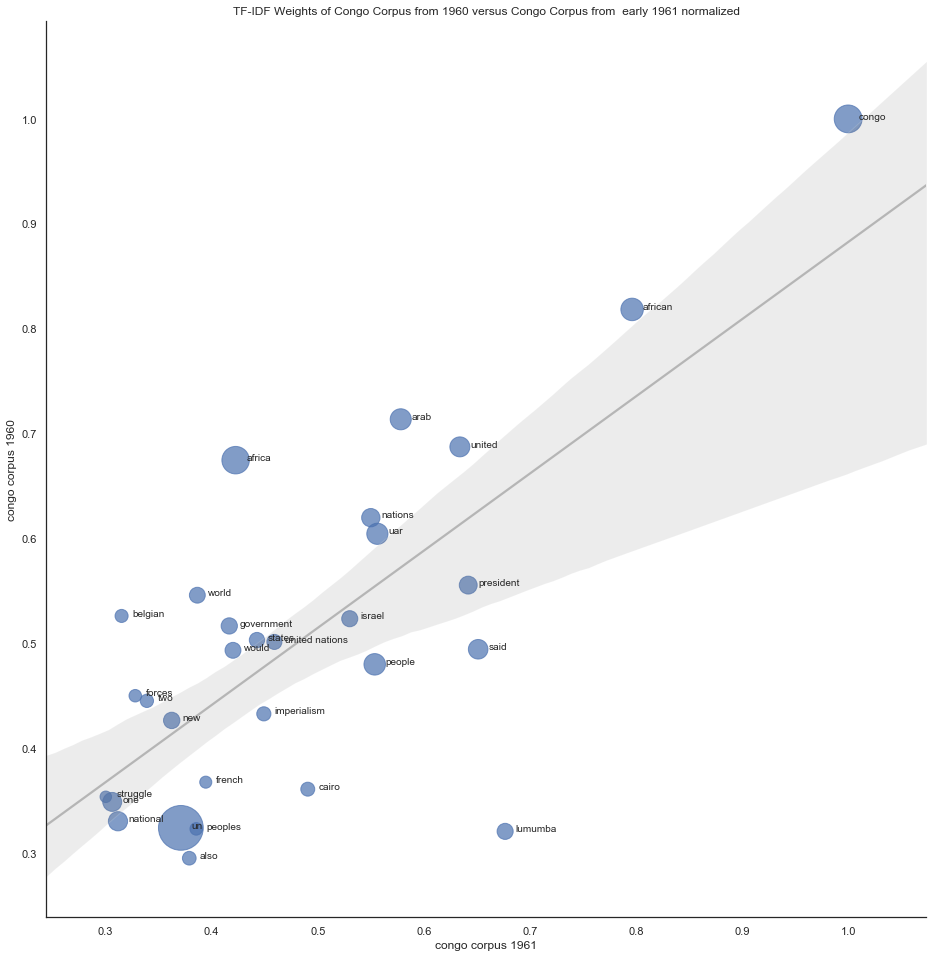

In [23]:
congo_1960_vs_1961 = plot_both_models(processed_both, 'TF-IDF Weights of Congo Corpus from 1960 versus Congo Corpus from  early 1961 normalized', 'congo corpus 1960', 'congo corpus 1961')
congo_1960_vs_1961

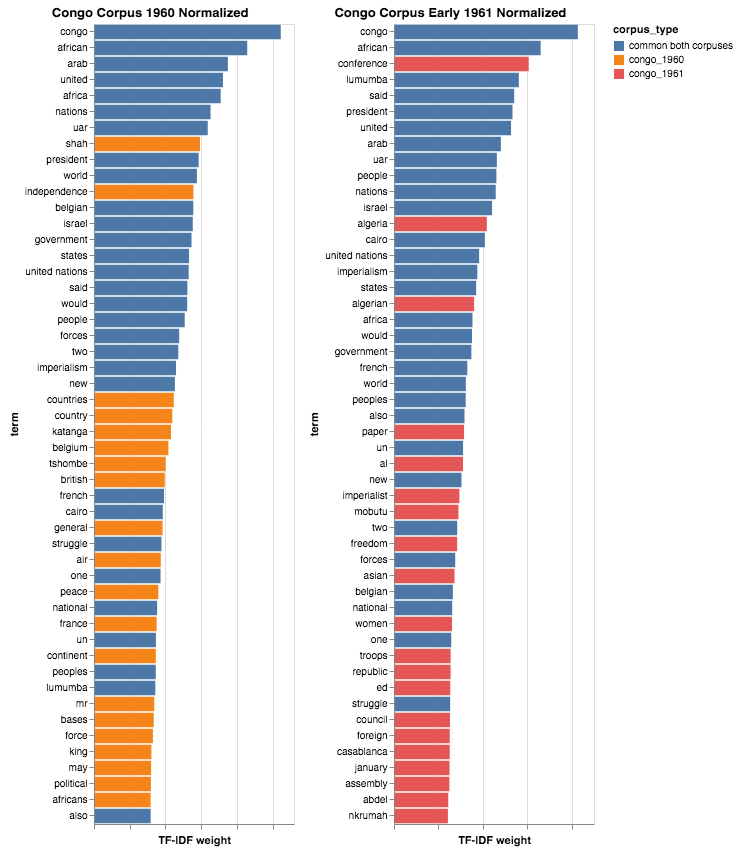

In [28]:
lists_1960_1961 = compare_model_lists(processed_congo_1960_url, processed_congo_1961_url, 'Congo Corpus 1960 Normalized', 'Congo Corpus Early 1961 Normalized')
lists_1960_1961

Visualization of TF-IDF model of pages that mention Congo 1960-1962 compared to 1963-1966

In [59]:
early_congo =  congo_corpus_df.loc[(congo_corpus_df.datetime < '1963-01-01')]
var_early_congo = variation(early_congo.cleaned_spacy_counts)
skew_early_congo = early_congo.cleaned_spacy_counts.skew()
kurtosis_early_congo = early_congo.cleaned_spacy_counts.kurtosis()
early_congo = early_congo.dropna(subset=['cleaned_spacy_text'])

norm_early_congo = normalize_texts(early_congo)

tfidf_early_congo, tfidf_early_congo_pages = create_tfidf_model(norm_early_congo, (1,1), 'early_congo', 50, 0.3)


late_congo = congo_corpus_df.loc[(congo_corpus_df.datetime > '1962-12-31')]

var_late_congo = variation(late_congo.cleaned_spacy_counts)
skew_late_congo = late_congo.cleaned_spacy_counts.skew()
kurtosis_late_congo = late_congo.cleaned_spacy_counts.kurtosis()
late_congo = late_congo.dropna(subset=['cleaned_spacy_text'])

norm_late_congo = normalize_texts(late_congo)
tfidf_late_congo, tfidf_late_congo_pages = create_tfidf_model(norm_late_congo, (1,1), 'late_congo', 50, 0.3)

congos = tfidf_early_congo.merge(tfidf_late_congo, on=['term'], how='outer')

processed_early_congo, processed_late_congo, processed_both = shape_corpus(congos, 'early_congo', 'late_congo')
processed_both = get_values(processed_both, congo_corpus_df)

In [61]:
list_early_congo = processed_early_congo.loc[(processed_early_congo.corpus_type == 'early_congo') ]
list_late_congo = processed_late_congo.loc[(processed_late_congo.corpus_type == 'late_congo') ]
ec_terms = list_early_congo.term.tolist()
lc_terms = list_late_congo.term.tolist()

ec_docs = tfidf_early_congo_pages.loc[tfidf_early_congo_pages.term.isin(ec_terms)]
lc_docs = tfidf_late_congo_pages.loc[tfidf_late_congo_pages.term.isin(lc_terms)]

In [62]:
processed_early_congo_url_tfidf = './data/processed_early_congo_tfidf.json'
ec_docs.to_json(processed_early_congo_url_tfidf, orient='records')
processed_late_congo_url_tfidf = './data/processed_late_congo_tfidf.json'
lc_docs.to_json(processed_late_congo_url_tfidf, orient='records')

processed_early_congo_url = './data/processed_early_congo.json'
processed_early_congo.to_json(processed_early_congo_url, orient='records')
processed_late_congo_url = './data/processed_late_congo.json'
processed_late_congo.to_json(processed_late_congo_url, orient='records')

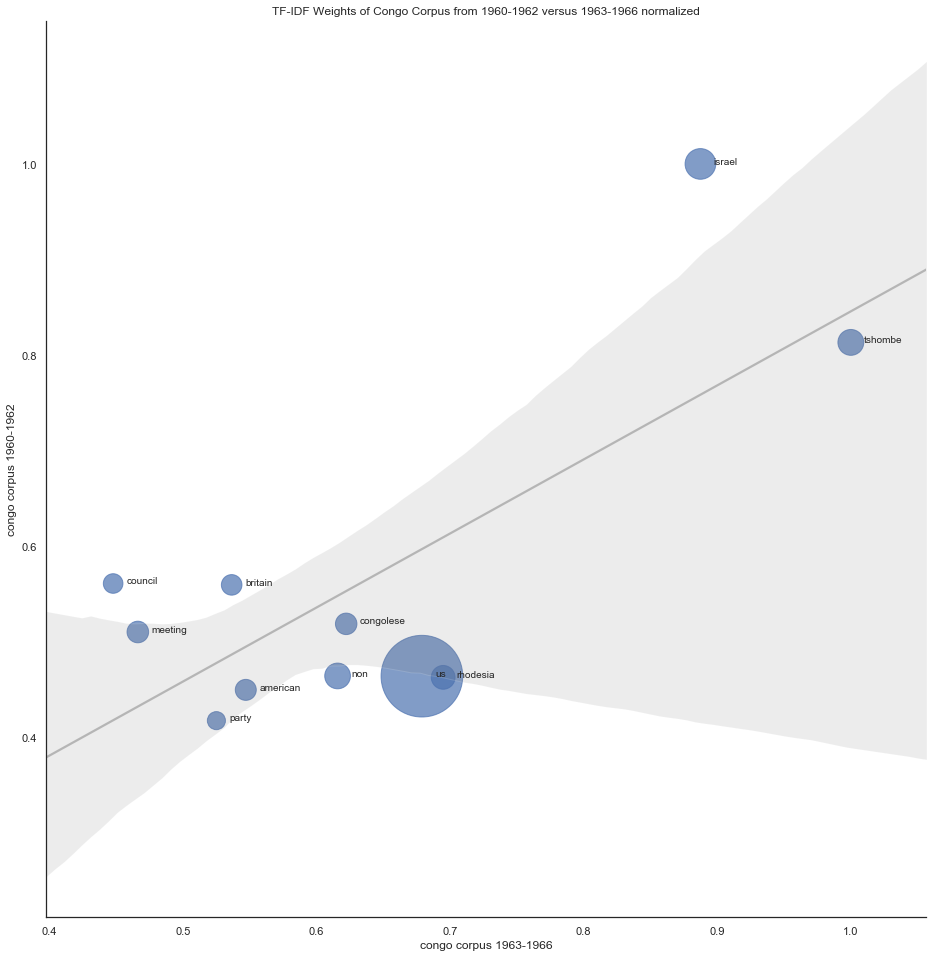

In [33]:
congo_1960s = plot_both_models(processed_both, 'TF-IDF Weights of Congo Corpus from 1960-1962 versus 1963-1966 normalized', 'congo corpus 1960-1962', 'congo corpus 1963-1966')
# summer_congo_1960

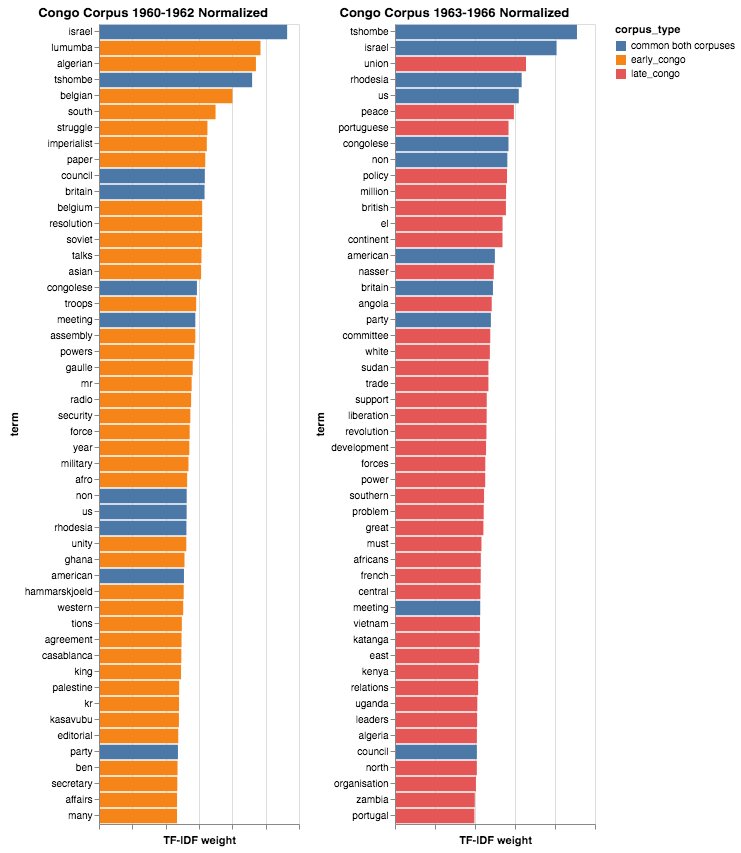

In [34]:
lists_1960s = compare_model_lists(processed_early_congo_url, processed_late_congo_url, 'Congo Corpus 1960-1962 Normalized', 'Congo Corpus 1963-1966 Normalized')
lists_1960s